In [1]:
import pandas as pd
import numpy as np
from math import log, sqrt, exp
from statistics import NormalDist # Requires Python 3.8+
# If using older Python, you might need scipy.stats.norm
# from scipy.stats import norm

# --- Assume BlackScholes Class is defined here ---
# (Using the refined version from the previous example with Newton-Raphson)
class BlackScholes:
    @staticmethod
    def black_scholes_call(spot, strike, time_to_expiry, volatility, risk_free_rate=0.0):
        # Note: Added risk_free_rate, assuming 0 if not provided
        if volatility <= 0 or time_to_expiry <= 0 or spot <= 0:
             # Intrinsic value at expiry, discounted back if r > 0
             return max(0.0, spot - strike * exp(-risk_free_rate * time_to_expiry))

        d1 = (
            log(spot / strike) + (risk_free_rate + 0.5 * volatility**2) * time_to_expiry
        ) / (volatility * sqrt(time_to_expiry))
        d2 = d1 - volatility * sqrt(time_to_expiry)
        call_price = spot * NormalDist().cdf(d1) - strike * exp(-risk_free_rate * time_to_expiry) * NormalDist().cdf(d2)
        return call_price

    @staticmethod
    def vega(spot, strike, time_to_expiry, volatility, risk_free_rate=0.0):
        if volatility <= 0 or time_to_expiry <= 0 or spot <= 0:
            return 0.0
        d1 = (
            log(spot / strike) + (risk_free_rate + 0.5 * volatility**2) * time_to_expiry
        ) / (volatility * sqrt(time_to_expiry))
        pdf_d1 = NormalDist().pdf(d1)
        # Returns price change per 1 vol point (1 = 100%)
        return spot * pdf_d1 * sqrt(time_to_expiry)

    @staticmethod
    def implied_volatility(
        call_price, spot, strike, time_to_expiry, risk_free_rate=0.0,
        initial_guess=0.5, max_iterations=100, tolerance=1e-6
    ):
        # --- Input Validation ---
        if call_price <= 0 or spot <= 0 or strike <= 0 or time_to_expiry <= 0:
            return np.nan # Cannot compute IV for invalid inputs

        min_call_price = max(0.0, spot - strike * exp(-risk_free_rate * time_to_expiry))
        if call_price < min_call_price - tolerance:
             # Price below intrinsic value (arbitrage)
             return np.nan

        max_call_price = spot # Price cannot exceed spot
        if call_price > max_call_price + tolerance:
            # Price exceeds maximum possible value
            return np.nan

        # --- Newton-Raphson Implementation ---
        vol = initial_guess
        for i in range(max_iterations):
            try:
                price = BlackScholes.black_scholes_call(spot, strike, time_to_expiry, vol, risk_free_rate)
                vega = BlackScholes.vega(spot, strike, time_to_expiry, vol, risk_free_rate)

                if vega < tolerance:
                     # Vega too small, likely deep ITM/OTM near expiry
                     # Or volatility is effectively zero. Cannot reliably use Newton-Raphson.
                     # If price is very close to intrinsic, vol is near 0.
                     # If price is far from intrinsic but vega is low, might be an issue.
                     # Check if price is already matched at this low-vega point
                     if abs(price - call_price) < tolerance:
                         return max(1e-4, vol) # Return small positive vol if price matches
                     return np.nan # Otherwise, cannot converge

                diff = price - call_price
                if abs(diff) < tolerance:
                    return max(1e-4, vol) # Return converged vol (ensure positive)

                # Newton-Raphson step
                vol = vol - diff / vega

                # Keep volatility within reasonable bounds
                vol = max(1e-4, min(vol, 4.0)) # e.g., 0.01% to 400%

            except (ValueError, OverflowError, ZeroDivisionError):
                return np.nan # Return NaN on numerical errors during iteration

        # If max_iterations reached without converging check final diff
        final_price = BlackScholes.black_scholes_call(spot, strike, time_to_expiry, vol, risk_free_rate)
        if abs(final_price - call_price) < tolerance * 10: # Looser tolerance at end
             return max(1e-4, vol)
        # print(f"WARN: IV calculation did not converge after {max_iterations} iterations. Final Diff: {abs(final_price-call_price)}")
        return np.nan # Return NaN if no convergence


# --- Calculation Function ---

def calculate_implied_volatility_df(df,
                                    option_price_col,
                                    spot_price_col,
                                    strike_price, # Fixed strike for the specific option
                                    day_col,
                                    timestamp_col,
                                    total_days_to_expiry_at_start=7,
                                    ticks_per_day=1_000_000,
                                    trading_days_per_year=250):
    """
    Calculates Implied Volatility for each row in a DataFrame,
    specifically for the options structure described.

    Args:
        df (pd.DataFrame): Merged DataFrame with aligned option and spot data.
        option_price_col (str): Column name for the option's mid_price.
        spot_price_col (str): Column name for the underlying's mid_price.
        strike_price (float): The fixed strike price of the option.
        day_col (str): Column name for the trading day (e.g., 1, 2, 3).
        timestamp_col (str): Column name for the timestamp within the day (0 to 1M).
        total_days_to_expiry_at_start (int): Total days TTE at the start of Day 1.
        ticks_per_day (int): Number of timestamp units representing one full day.
        trading_days_per_year (int): Convention for converting days to years.

    Returns:
        pd.Series: A Series containing the calculated implied volatility for each row.
    """
    # --- 1. Calculate Time to Expiry (TTE) ---
    # Assumes 'day' column is 1, 2, or 3 for the available data
    # Assumes expiry happens at the END of the 7th day.
    # At timestamp 'ts' on day 'd':
    # Full days remaining AFTER the current day = total_days_to_expiry_at_start - day
    # Fraction of CURRENT day remaining = (ticks_per_day - timestamp) / ticks_per_day
    full_days_remaining = total_days_to_expiry_at_start - df[day_col]
    fraction_of_current_day_remaining = (ticks_per_day - df[timestamp_col]) / ticks_per_day

    # Total remaining days = full days left + fraction of current day left
    total_remaining_days = full_days_remaining + fraction_of_current_day_remaining

    # Convert to years
    tte_years = total_remaining_days / trading_days_per_year

    # Clip TTE to avoid issues near zero
    tte_years = tte_years.clip(lower=1e-9)

    # --- 2. Define Apply Function ---
    # Use a lambda for slightly faster application than a defined function
    calculate_row_iv = lambda row: BlackScholes.implied_volatility(
        call_price=row[option_price_col],
        spot=row[spot_price_col],
        strike=strike_price, # Use the fixed strike passed in
        time_to_expiry=row['tte_years']
        # Assuming risk_free_rate = 0 for simplicity
    )

    # --- 3. Apply Calculation Row-wise ---
    print(f"Calculating Implied Volatility for Strike {strike_price}...")
    # Add tte_years column temporarily for the apply function
    df_temp = df.assign(tte_years=tte_years)
    implied_volatility_series = df_temp.apply(calculate_row_iv, axis=1)
    print("Calculation complete.")

    return implied_volatility_series
    
# --- Main Execution Block ---


In [2]:
day1 = "/Users/sarthak/Desktop/imc/round_4/round-4-island-data-bottle/prices_round_4_day_1.csv"
day2 = "/Users/sarthak/Desktop/imc/round_4/round-4-island-data-bottle/prices_round_4_day_2.csv"
day3 = "/Users/sarthak/Desktop/imc/round_4/round-4-island-data-bottle/prices_round_4_day_3.csv"
day4 = "/Users/sarthak/Desktop/imc/round_5/round-5-island-data-bottle/prices_round_5_day_4.csv"
day_1 = pd.read_csv(day1,delimiter=';')
day_2 = pd.read_csv(day2,delimiter=';')
day_3 = pd.read_csv(day3,delimiter=';')
day_4 = pd.read_csv(day4,delimiter=';')

In [3]:
final = pd.concat([day_2,day_3,day_4],axis=0)
final.head()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,2,0,PICNIC_BASKET2,30094.0,11.0,30093.0,27.0,NaN,NaN,30099.0,1.0,30100.0,37.0,NaN,NaN,30096.5,0.0
1,2,0,VOLCANIC_ROCK_VOUCHER_9750,469.0,11.0,NaN,NaN,NaN,NaN,470.0,11.0,NaN,NaN,NaN,NaN,469.5,0.0
2,2,0,RAINFOREST_RESIN,9992.0,35.0,NaN,NaN,NaN,NaN,10008.0,35.0,NaN,NaN,NaN,NaN,10000.0,0.0
3,2,0,VOLCANIC_ROCK_VOUCHER_9500,718.0,11.0,NaN,NaN,NaN,NaN,719.0,11.0,NaN,NaN,NaN,NaN,718.5,0.0
4,2,0,VOLCANIC_ROCK,10218.0,150.0,10217.0,64.0,NaN,NaN,10219.0,150.0,10220.0,64.0,NaN,NaN,10218.5,0.0


In [4]:
final.columns

Index(['day', 'timestamp', 'product', 'bid_price_1', 'bid_volume_1',
       'bid_price_2', 'bid_volume_2', 'bid_price_3', 'bid_volume_3',
       'ask_price_1', 'ask_volume_1', 'ask_price_2', 'ask_volume_2',
       'ask_price_3', 'ask_volume_3', 'mid_price', 'profit_and_loss'],
      dtype='object')

Preparing data for VOLCANIC_ROCK_VOUCHER_10000 and VOLCANIC_ROCK...
Data prepared. Found 30000 matching timestamps.
Calculating Implied Volatility for Strike 10000...
Calculation complete.

Merged DataFrame with Implied Volatility:
   day  timestamp  mid_price_option  mid_price_spot  implied_volatility
0    2          0             233.5         10218.5            0.130783
1    2        100             234.5         10217.5            0.135903
2    2        200             235.5         10222.0            0.127826
3    2        300             235.5         10223.0            0.125207
4    2        400             234.5         10217.0            0.137044

--- Results for VOLCANIC_ROCK_VOUCHER_10000 (Strike: 10000) ---
Calculated Mean Implied Volatility:   0.127791
Calculated Median Implied Volatility: 0.127673
Calculated Std Dev Implied Volatility:0.005418
Number of Valid IV Points:          30000 / 30000


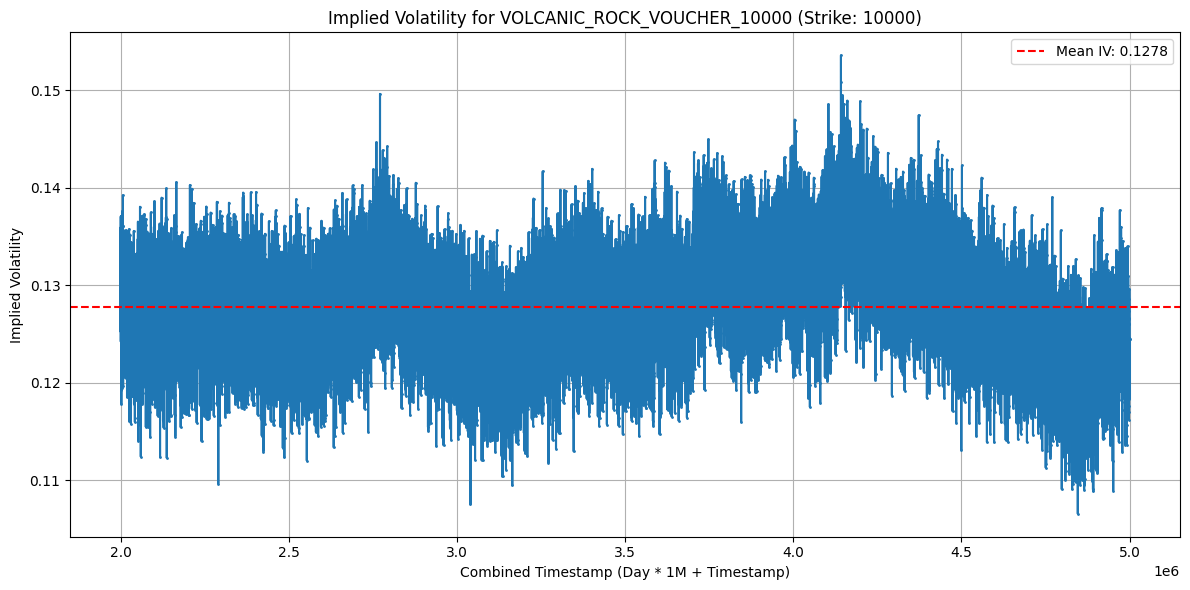

Preparing data for VOLCANIC_ROCK_VOUCHER_10000 and VOLCANIC_ROCK...
Data prepared. Found 30000 matching timestamps.
Calculating Implied Volatility for Strike 10250...
Calculation complete.

Merged DataFrame with Implied Volatility:
   day  timestamp  mid_price_option  mid_price_spot  implied_volatility
0    2          0             233.5         10218.5            0.393621
1    2        100             234.5         10217.5            0.395987
2    2        200             235.5         10222.0            0.394061
3    2        300             235.5         10223.0            0.393282
4    2        400             234.5         10217.0            0.396386

--- Results for VOLCANIC_ROCK_VOUCHER_10000 (Strike: 10250) ---
Calculated Mean Implied Volatility:   0.348056
Calculated Median Implied Volatility: 0.341144
Calculated Std Dev Implied Volatility:0.059118
Number of Valid IV Points:          30000 / 30000


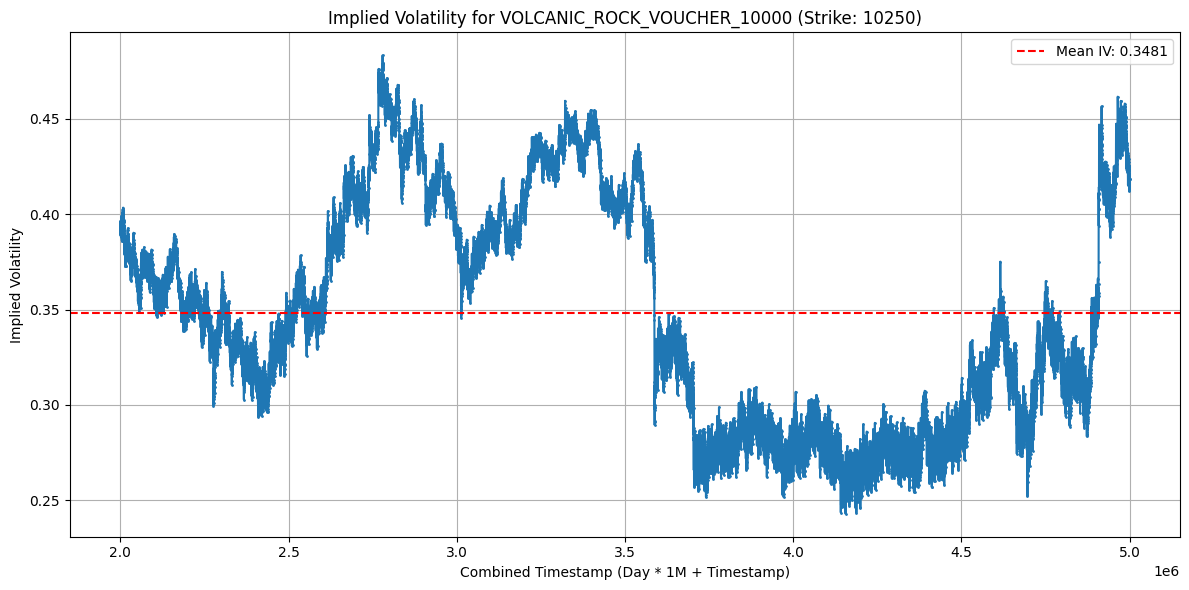

Preparing data for VOLCANIC_ROCK_VOUCHER_10000 and VOLCANIC_ROCK...
Data prepared. Found 30000 matching timestamps.
Calculating Implied Volatility for Strike 10500...
Calculation complete.

Merged DataFrame with Implied Volatility:
   day  timestamp  mid_price_option  mid_price_spot  implied_volatility
0    2          0             233.5         10218.5            0.557367
1    2        100             234.5         10217.5            0.559660
2    2        200             235.5         10222.0            0.558397
3    2        300             235.5         10223.0            0.557754
4    2        400             234.5         10217.0            0.559997

--- Results for VOLCANIC_ROCK_VOUCHER_10000 (Strike: 10500) ---
Calculated Mean Implied Volatility:   0.500164
Calculated Median Implied Volatility: 0.493606
Calculated Std Dev Implied Volatility:0.082917
Number of Valid IV Points:          30000 / 30000


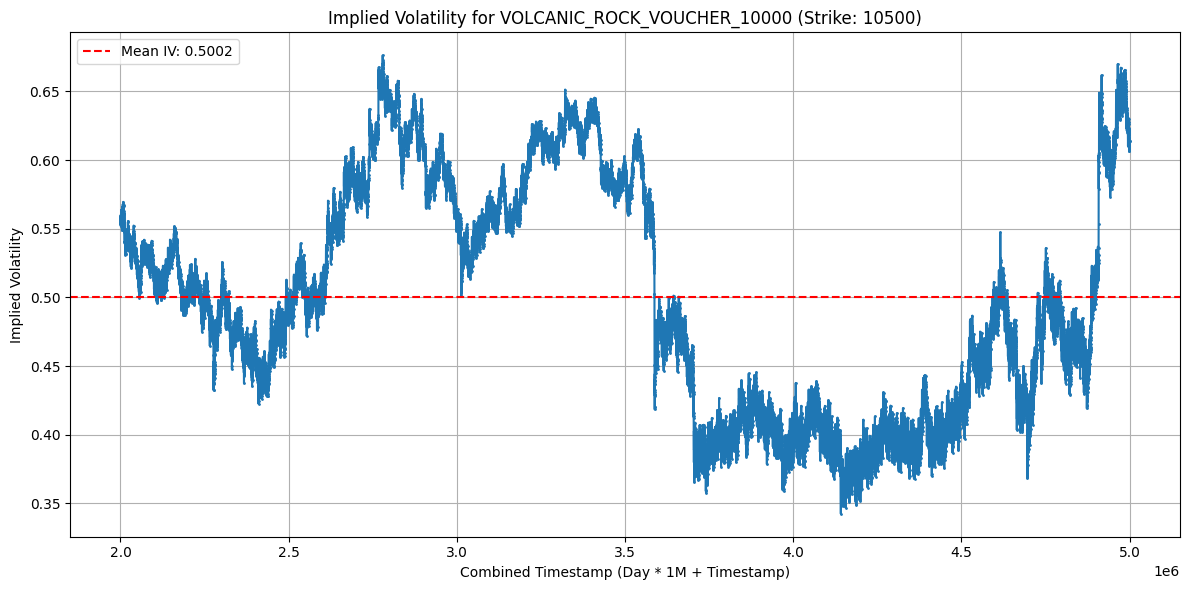

In [5]:

if __name__ == '__main__':
    # --- Configuration ---
    OPTION_TICKER = 'VOLCANIC_ROCK_VOUCHER_10000' # Choose ONE option
    UNDERLYING_TICKER = 'VOLCANIC_ROCK' # Assuming this is the underlying name
    STRIKE_PRICE = 10000            # Corresponding strike price
    TRADING_DAYS_PER_YEAR = 250        # Standard convention
    TICKS_PER_DAY = 1_000_000          # Timestamps per day
    TOTAL_DAYS_TO_EXPIRY_AT_START = 7  # Initial TTE in days

    # --- Load Data ---
    # Replace this with your actual data loading
    # Example: final = pd.read_csv('your_data.csv')
    # # For demonstration, creating a dummy DataFrame:
    # print("Creating dummy data (replace with actual loading)...")
    # days = np.repeat([1, 2, 3], TICKS_PER_DAY // 10000 +1)[:300] # Smaller dummy data
    # timestamps = np.tile(np.arange(0, TICKS_PER_DAY + 1, 10000), 3)[:300]

    # dummy_data = []
    # base_spot = 9900
    # base_vol = 0.25
    # for d, ts in zip(days, timestamps):
    #     spot_price = base_spot + (d-1)*100 + (ts/TICKS_PER_DAY)*200 + np.random.randn()*20
    #     # Calculate TTE for dummy price generation
    #     full_days_rem = TOTAL_DAYS_TO_EXPIRY_AT_START - d
    #     frac_day_rem = (TICKS_PER_DAY - ts) / TICKS_PER_DAY
    #     tte_gen = (full_days_rem + frac_day_rem) / TRADING_DAYS_PER_YEAR
    #     tte_gen = max(tte_gen, 1e-9)
    #     option_price = BlackScholes.black_scholes_call(spot_price, STRIKE_PRICE, tte_gen, base_vol + np.random.randn()*0.02)
    #     option_price = max(0.1, option_price + np.random.uniform(-0.5,0.5)) # Add noise

    #     dummy_data.append({'day': d, 'timestamp': ts, 'product': UNDERLYING_TICKER, 'mid_price': spot_price})
    #     dummy_data.append({'day': d, 'timestamp': ts, 'product': OPTION_TICKER, 'mid_price': option_price})
    #      # Add other options too for filtering realism
    #     dummy_data.append({'day': d, 'timestamp': ts, 'product': 'VOLCANIC_ROCK_VOUCHER_9500', 'mid_price': option_price*0.8})


    # final = pd.DataFrame()
    # print("Dummy data created.")
    # print(final.head()) # Optional: print head of raw data

    # --- Data Preparation ---
    for STRIKE_PRICE in [10000,10250,10500]: 
        print(f"Preparing data for {OPTION_TICKER} and {UNDERLYING_TICKER}...")
        # 1. Filter for the specific option and underlying
        option_data = final[final['product'] == OPTION_TICKER].copy()
        spot_data = final[final['product'] == UNDERLYING_TICKER].copy()

        if option_data.empty:
            print(f"Error: No data found for option ticker '{OPTION_TICKER}'")
            exit()
        if spot_data.empty:
            print(f"Error: No data found for underlying ticker '{UNDERLYING_TICKER}'")
            exit()

        # 2. Merge based on day and timestamp to align prices
        # Keep only essential columns for the merge
        option_data_slim = option_data[['day', 'timestamp', 'mid_price']]
        spot_data_slim = spot_data[['day', 'timestamp', 'mid_price']]

        merged_data = pd.merge(
            option_data_slim,
            spot_data_slim,
            on=['day', 'timestamp'],
            how='inner', # Only keep timestamps where BOTH have data
            suffixes=('_option', '_spot') # Rename mid_price columns
        )

        if merged_data.empty:
            print("Error: No matching timestamps found between option and underlying data after merge.")
            exit()

        print(f"Data prepared. Found {len(merged_data)} matching timestamps.")
        # print(merged_data.head()) # Optional: print head of merged data

        # --- Calculate Implied Volatility ---
        merged_data['implied_volatility'] = calculate_implied_volatility_df(
            df=merged_data,
            option_price_col='mid_price_option',
            spot_price_col='mid_price_spot',
            strike_price=STRIKE_PRICE,
            day_col='day',
            timestamp_col='timestamp',
            total_days_to_expiry_at_start=TOTAL_DAYS_TO_EXPIRY_AT_START,
            ticks_per_day=TICKS_PER_DAY,
            trading_days_per_year=TRADING_DAYS_PER_YEAR
        )

        print("\nMerged DataFrame with Implied Volatility:")
        print(merged_data.head())

        # --- Calculate Mean Volatility ---
        valid_iv = merged_data['implied_volatility'].dropna()

        if not valid_iv.empty:
            mean_iv = valid_iv.mean()
            median_iv = valid_iv.median()
            std_iv = valid_iv.std()
            print(f"\n--- Results for {OPTION_TICKER} (Strike: {STRIKE_PRICE}) ---")
            print(f"Calculated Mean Implied Volatility:   {mean_iv:.6f}")
            print(f"Calculated Median Implied Volatility: {median_iv:.6f}")
            print(f"Calculated Std Dev Implied Volatility:{std_iv:.6f}")
            print(f"Number of Valid IV Points:          {len(valid_iv)} / {len(merged_data)}")

            # This 'mean_iv' is the value you would use for 'mean_volatility'
            # in your PARAMS dictionary for this specific option.

        else:
            print(f"\nCould not calculate valid Implied Volatility for {OPTION_TICKER}.")

        # --- Optional: Plotting ---
        try:
            import matplotlib.pyplot as plt
            plt.figure(figsize=(12, 6))
            # Create a combined time axis for plotting across days
            merged_data['combined_time'] = merged_data['day'] * TICKS_PER_DAY + merged_data['timestamp']
            plt.plot(merged_data['combined_time'], merged_data['implied_volatility'], marker='.', linestyle='-', markersize=2)
            plt.title(f'Implied Volatility for {OPTION_TICKER} (Strike: {STRIKE_PRICE})')
            plt.xlabel('Combined Timestamp (Day * 1M + Timestamp)')
            plt.ylabel('Implied Volatility')
            plt.grid(True)
            # Add horizontal line for the mean
            if not valid_iv.empty:
                plt.axhline(mean_iv, color='r', linestyle='--', label=f'Mean IV: {mean_iv:.4f}')
                plt.legend()
                plt.tight_layout()
                plt.show()
        except ImportError:
            print("\nInstall matplotlib to see the plot (pip install matplotlib)")
        except Exception as e:
            print(f"\nError during plotting: {e}")